<div class="alert alert-block alert-info">
<b>Tip:</b> Install the jupyter notebook first.
</div>

# Installing Jupyter Notebook in terminal

```bash
# Navigate to the home directory
cd ~

# Install Jupyter Notebook using pip3
pip3 install jupyter


In [2]:
# import modulus
import pandas as pd
# import os
# script_path = 'missing_table.py'
# os.system(f'python3 {script_path}')
# !python missing_table.py
# from missing_table import missing_value_df
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
# This function converts the string into the type of datetime %d/%m/%Y
def convert_date_format(date_str):
    try:
        date_time_obj = datetime.strptime(date_str, '%d/%m/%Y %H:%M')
        formatted_date = date_time_obj.strftime('%m/%d/%Y')
        return formatted_date
    except ValueError:
        pass

    try:
        date_time_obj = datetime.strptime(date_str, '%d/%m/%Y')
        return date_str
    except ValueError:
        raise ValueError(f"Unsupported date format: {date_str}")

In [4]:
#  count the week in per week or fornightly
slice = 14

# Plot without threshold

In [5]:
# Without threshold:
# note: More needs to be added to this script to clean the columns as needs be
# edit: 

# edit: changed filed path
df0 = pd.read_csv("../raw_data/australia.csv",
                 na_values=[" ", "__NA__", "NAN"], keep_default_na = True, low_memory=False)

# create a new column in the csv that computer from week 1 for every two weeks 
df0["endtime"] = df0["endtime"].apply(convert_date_format)
df0["endtime"] = pd.to_datetime(df0["endtime"])
df0 = df0.sort_values(by=["endtime"])
# Find the start date (minimum date) and end date (maximum date)
start_date = df0['endtime'].min()
end_date = df0['endtime'].max()

# Create a new column 'week_number' and assign week numbers
df0['week_number'] = ((df0['endtime'] - start_date).dt.days // slice) + 1

frequency_dict = {"Always": 1, "Frequently": 1, "Sometimes": 0, "Rarely": 0, "Not at all": 0}
df0["i12_health_1"] = df0["i12_health_1"].map(frequency_dict)

df0_count = df0.groupby(["week_number", "endtime", "state", "i12_health_1"]).size().unstack(fill_value=0).reset_index()
df0_count.columns = ["week_number", "endtime", "state", 
                    "wearing mask = 'No'", "wearing mask = 'Yes'"]
# plot figures in states. proportion
df0_count["prop_no"] = df0_count["wearing mask = 'No'"] / (df0_count["wearing mask = 'No'"] + df0_count["wearing mask = 'Yes'"])
df0_count["prop_yes"] = df0_count["wearing mask = 'Yes'"] / (df0_count["wearing mask = 'No'"] + df0_count["wearing mask = 'Yes'"])
# the regulation dates
states_data = {
    "Australian Capital Territory": ["28/6/2021", "25/2/2022"],
    "New South Wales": ["4/1/2021", "20/9/2022"],
    "Northern Territory": ["19/12/2021", "5/3/2022"],
    "Queensland": ["18/12/2021", "7/3/2022"],
    "South Australia": ["27/7/2021", "20/9/2022"],
    "Tasmania": ["21/12/2021", "5/3/2022"],
    "Victoria": ["16/8/2020", "22/9/2022"], 
    "Western Australia": ["23/4/2021", "9/9/2022"]
}
# # Plotting figures for each state in two columns
# states = df0_count["state"].unique()
# num_states = len(states)
# cols = len(df0.columns)
# rows = len(df0)

# fig, axes = plt.subplots(num_states // 2, 2, figsize=(15, 5 * (num_states // 2 + num_states % 2)))

# for idx, state in enumerate(states):
#     ax = axes[idx // 2, idx % 2] if num_states > 1 else axes
    
#     state_df0 = df0_count[df0_count["state"] == state]
    
#     ax.bar(state_df0["week_number"], state_df0["prop_yes"], label="Wearing Mask = 'Yes'")
#     ax.bar(state_df0["week_number"], state_df0["prop_no"], bottom=state_df0["prop_yes"], label="Wearing Mask = 'No'")
    
#     # Add vertical lines for start and end times
#     start_time, end_time = states_data[state]
        
#     if start_time:
#         start_time = pd.to_datetime(start_time, format='%d/%m/%Y')
#         ax.axvline(x=((start_time - start_date).days // slice) + 1, color='purple', linestyle='--', linewidth = 3, label='Face mask mandate Starts')
#     if end_time and (state == "Australian Capital Territory" or state == "Queensland" or state == "Tasmania"):
#         end_time = pd.to_datetime(end_time, format='%d/%m/%Y')
#         ax.axvline(x=((end_time - start_date).days // slice) + 1, color='yellow', linestyle='--', linewidth = 3, label='Face mask mandate Ends')
        
#     ax.set_title(f"Percentage of Wearing Mask outside home in {state}")
#     ax.set_xlabel("End time")
#     ax.set_ylabel("Percentage")
#     ax.set_xlim(0,52)
#     ax.set_ylim(0, 1)  # Fixing y-axis at 1
#     ax.text(0.9, 0.9, f"No. of cleaned columns is {rows}x{cols}")
#     ax.legend()

# plt.tight_layout()
# plt.savefig("../figures/states_in_proportion_threshold0.png")
# plt.show()

# Plot with less than 1006 missing value

In [ ]:
df = pd.read_csv("../raw_data/australia.csv",
                 na_values=[" ", "__NA__", "NAN"], keep_default_na = True, low_memory=False)
df["endtime"] = df["endtime"].apply(convert_date_format)
df["endtime"] = pd.to_datetime(df["endtime"])
df = df.sort_values(by=["endtime"])
# Find the start date (minimum date) and end date (maximum date)
start_date = df['endtime'].min()
end_date = df['endtime'].max()

# Create a new column 'week_number' and assign week numbers
df['week_number'] = ((df['endtime'] - start_date).dt.days // slice) + 1

frequency_dict = {"Always": 1, "Frequently": 1, "Sometimes": 0, "Rarely": 0, "Not at all": 0}
df["i12_health_1"] = df["i12_health_1"].map(frequency_dict)
# Filter out the day with less than 5 data points
# df_grouped_size = df.groupby("endtime").size()

# # Filter out groups with sizes less than 5
# valid_endtimes = df_grouped_size[df_grouped_size >= 0].index

# # Filter the original DataFrame to keep only rows with valid endtimes
# df = df[df["week_number"].isin(valid_endtimes)]

# Set the threshold for missing value count
# edit: change cound to 1006
thresh_value = 1006

# Extract the variable names with missing value counts larger than 1006
columns_to_drop = missing_value_df.loc[missing_value_df['Missing Value Count']
                                       > thresh_value, 'Variable Name'].tolist()

df.drop(columns=columns_to_drop, inplace=True)
df.dropna(inplace=True)

print(df)

In [ ]:
# plot states_in_proportion pre-setting

# Assuming df is your original dataframe
df_count = df.groupby(["week_number", "endtime", "state", "i12_health_1"]).size().unstack(fill_value=0).reset_index()
df_count.columns = ["week_number", "endtime", "state", 
                    "wearing mask = 'No'", "wearing mask = 'Yes'"]
# plot figures in states. proportion
df_count["prop_no"] = df_count["wearing mask = 'No'"] / (df_count["wearing mask = 'No'"] + df_count["wearing mask = 'Yes'"])
df_count["prop_yes"] = df_count["wearing mask = 'Yes'"] / (df_count["wearing mask = 'No'"] + df_count["wearing mask = 'Yes'"])
# the regulation dates
states_data = {
    "Australian Capital Territory": ["28/6/2021", "25/2/2022"],
    "New South Wales": ["4/1/2021", "20/9/2022"],
    "Northern Territory": ["19/12/2021", "5/3/2022"],
    "Queensland": ["18/12/2021", "7/3/2022"],
    "South Australia": ["27/7/2021", "20/9/2022"],
    "Tasmania": ["21/12/2021", "5/3/2022"],
    "Victoria": ["16/8/2020", "22/9/2022"], 
    "Western Australia": ["23/4/2021", "9/9/2022"]
}

print(df_count[df_count["state"]== "Australian Capital Territory"])

In [ ]:
# Plotting figures for each state in two columns
states = df_count["state"].unique()
num_states = len(states)
cols = len(df.columns)
rows = len(df)

fig, axes = plt.subplots(num_states // 2, 2, figsize=(15, 5 * (num_states // 2 + num_states % 2)))

for idx, state in enumerate(states):
    ax = axes[idx // 2, idx % 2] if num_states > 1 else axes
    
    state_df = df_count[df_count["state"] == state]
    
    ax.bar(state_df["week_number"], state_df["prop_yes"], label="Wearing Mask = 'Yes'")
    ax.bar(state_df["week_number"], state_df["prop_no"], bottom=state_df["prop_yes"], label="Wearing Mask = 'No'")
    
    # Add vertical lines for start and end times
    start_time, end_time = states_data[state]
        
    if start_time:
        start_time = pd.to_datetime(start_time, format='%d/%m/%Y')
        ax.axvline(x=((start_time - start_date).days // slice) + 1, color='purple', linestyle='--', linewidth = 3, label='Face mask mandate Starts')
    if end_time and (state == "Australian Capital Territory" or state == "Queensland" or state == "Tasmania"):
        end_time = pd.to_datetime(end_time, format='%d/%m/%Y')
        ax.axvline(x=((end_time - start_date).days // slice) + 1, color='yellow', linestyle='--', linewidth = 3, label='Face mask mandate Ends')
        
    ax.set_title(f"Percentage of Wearing Mask outside home in {state}")
    ax.set_xlabel("End time")
    ax.set_ylabel("Percentage")
    ax.set_xlim(0,52)
    ax.set_ylim(0, 1)  # Fixing y-axis at 1
    ax.text(0.9, 0.9, f"No. of cleaned columns is {rows}x{cols}")
    ax.legend()

plt.tight_layout()

plt.savefig("../figures/states_in_proportion_threshold1006.png")
plt.show()

# Plot those columns with less than 10029 missing value

In [ ]:
# ANOTHER TRY: threshold = 10029
# note: More needs to be added to this script to clean the columns as needs be

# edit: changed filed path
df2 = pd.read_csv("../raw_data/australia.csv",
                 na_values=[" ", "__NA__", "NAN"], keep_default_na = True, low_memory=False)

# create a new column in the csv that computer from week 1 for every two weeks 
df2["endtime"] = df2["endtime"].apply(convert_date_format)
df2["endtime"] = pd.to_datetime(df2["endtime"])

# Find the start date (minimum date) and end date (maximum date)
start_date = df2['endtime'].min()
end_date = df2['endtime'].max()

# Create a new column 'week_number' and assign week numbers
df2['week_number'] = ((df2['endtime'] - start_date).dt.days // slice) + 1

# Filter out the day with less than 300 data points
# df2_grouped_size = df2.groupby("week_number").size()

# # Filter out groups with sizes less than 300
# valid_endtimes = df2_grouped_size[df2_grouped_size >= 0].index

# # Filter the original DataFrame to keep only rows with valid endtimes
# df2 = df2[df2["week_number"].isin(valid_endtimes)]

# print(df2_grouped_size)
# Set the threshold for missing value count
# edit: change cound to 10029
thresh_value = 70014

# Extract the variable names with missing value counts larger than 10029
columns_to_drop = missing_value_df.loc[missing_value_df['Missing Value Count']
                                       > thresh_value, 'Variable Name'].tolist()

df2.drop(columns=columns_to_drop, inplace=True)
df2.dropna(inplace=True)

states_data = {
    "Australian Capital Territory": ["28/6/2021", "25/2/2022"],
    "New South Wales": ["4/1/2021", "20/9/2022"],
    "Northern Territory": ["19/12/2021", "5/3/2022"],
    "Queensland": ["18/12/2021", "7/3/2022"],
    "South Australia": ["27/7/2021", "20/9/2022"],
    "Tasmania": ["21/12/2021", "5/3/2022"],
    "Victoria": ["16/8/2020", "22/9/2022"], 
    "Western Australia": ["23/4/2021", "9/9/2022"]
}

print(df2)

In [ ]:
# plot states_in_proportion pre-setting

df2["endtime"] = pd.to_datetime(df2["endtime"])   
df2 = df2.sort_values(by=["endtime"])

frequency_dict = {"Always": 1, "Frequently": 1, "Sometimes": 0, "Rarely": 0, "Not at all": 0}
df2["i12_health_1"] = df2["i12_health_1"].map(frequency_dict)

# Assuming df2 is original dataframe
df2_count = df2.groupby(["week_number", "endtime", "state", "i12_health_1"]).size().unstack(fill_value=0).reset_index()
df2_count.columns = ["week_number", "endtime", "state", 
                    "wearing mask = 'No'", "wearing mask = 'Yes'"]
# plot figures in states. proportion
df2_count["prop_no"] = df2_count["wearing mask = 'No'"] / (df2_count["wearing mask = 'No'"] + df2_count["wearing mask = 'Yes'"])
df2_count["prop_yes"] = df2_count["wearing mask = 'Yes'"] / (df2_count["wearing mask = 'No'"] + df2_count["wearing mask = 'Yes'"])

print(df2_count[df2_count["state"]== "Australian Capital Territory"])

In [ ]:
# Plotting figures for each state in two columns
states = df_count["state"].unique()
num_states = len(states)
cols = len(df2.columns)
rows = len(df2)

fig, axes = plt.subplots(num_states // 2, 2, figsize=(15, 5 * (num_states // 2 + num_states % 2)))

for idx, state in enumerate(states):
    ax = axes[idx // 2, idx % 2] if num_states > 1 else axes
    
    state_df2 = df2_count[df2_count["state"] == state]
    
    ax.bar(state_df2["week_number"], state_df2["prop_yes"], label="Wearing Mask = 'Yes'")
    ax.bar(state_df2["week_number"], state_df2["prop_no"], bottom=state_df2["prop_yes"], label="Wearing Mask = 'No'")
    
    # Add vertical lines for start and end times
    start_time, end_time = states_data[state]
    if start_time:
        start_time = pd.to_datetime(start_time, format='%d/%m/%Y')
        ax.axvline(x=((start_time - start_date).days // slice) + 1, color='purple', linestyle='--', linewidth = 3, label='Face mask mandate Starts')
    if end_time and (state == "Australian Capital Territory" or state == "Queensland" or state == "Tasmania"):
        end_time = pd.to_datetime(end_time, format='%d/%m/%Y')
        ax.axvline(x=((end_time - start_date).days // slice) + 1, color='yellow', linestyle='--', linewidth = 3, label='Face mask mandate Ends')
        
    ax.set_title(f"Percentage of Wearing Mask outside home in {state}")
    ax.set_xlabel("Week time")
    ax.set_ylabel("Percentage")
    ax.set_xlim(0, 52)
    ax.set_ylim(0, 1)  # Fixing y-axis at 1
    ax.text(0.9, 0.9, f"No. of cleaned columns is {rows}x{cols}")
    ax.legend()

plt.tight_layout()

plt.savefig("../figures/states_in_proportion_threshold10029.png")
plt.show()

In [ ]:
# Save the cleaned DataFrame to a new CSV file
# edit: fixed file path/save location
# df.to_csv("../data/cleaned_data.csv", index=False)

# Plot with proportion of the gender and state through time

In [ ]:
# Observe the gender & state to see the proportion of the survey through the time
df3 = pd.read_csv("../raw_data/australia.csv",
                 na_values=[" ", "__NA__", "NAN"], keep_default_na = True, low_memory=False)

# Filter out the day with less than 5 data points
df3_grouped_size = df3.groupby("endtime").size()

# Filter out groups with sizes less than 5
valid_endtimes = df3_grouped_size[df3_grouped_size >= 0].index

# Filter the original DataFrame to keep only rows with valid endtimes
df3 = df3[df3["endtime"].isin(valid_endtimes)]

# create a new column in the csv that computer from week 1 for every two weeks 
df3["endtime"] = df3["endtime"].apply(convert_date_format)
df3["endtime"] = pd.to_datetime(df3["endtime"])

# Find the start date (minimum date) and end date (maximum date)
start_date = df3['endtime'].min()
end_date = df3['endtime'].max()

# Create a new column 'week_number' and assign week numbers
df3['week_number'] = ((df3['endtime'] - start_date).dt.days // slice) + 1

# Set the threshold for missing value count
# edit: change cound to 1006
thresh_value = 1006

# Extract the variable names with missing value counts larger than 1006
columns_to_drop = missing_value_df.loc[missing_value_df['Missing Value Count']
                                       > thresh_value, 'Variable Name'].tolist()

df3.drop(columns=columns_to_drop, inplace=True)
df3.dropna(inplace=True)

states_data = {
    "Australian Capital Territory": ["28/6/2021", "25/2/2022"],
    "New South Wales": ["4/1/2021", "20/9/2022"],
    "Northern Territory": ["19/12/2021", "5/3/2022"],
    "Queensland": ["18/12/2021", "7/3/2022"],
    "South Australia": ["27/7/2021", "20/9/2022"],
    "Tasmania": ["21/12/2021", "5/3/2022"],
    "Victoria": ["16/8/2020", "22/9/2022"], 
    "Western Australia": ["23/4/2021", "9/9/2022"]
}

print(df3)

In [ ]:
# plot gender
df3["endtime"] = pd.to_datetime(df3["endtime"])   
df3 = df3.sort_values(by=["endtime"])

# Assuming df3 is original dataframe
df3_count = df3.groupby(["week_number", "endtime", "gender"]).size().unstack(fill_value=0).reset_index()
df3_count.columns = ["week_number", "endtime", 
                    "Male_no.", "Female_no."]

# plot figures in states. proportion
df3_count["Male"] = df3_count["Male_no."] / (df3_count["Male_no."] + df3_count["Female_no."])
df3_count["Female"] = df3_count["Female_no."] / (df3_count["Male_no."] + df3_count["Female_no."])

print(df3_count)

plt.bar(df3_count["week_number"], df3_count["Female"], label="Female")
plt.bar(df3_count["week_number"], df3_count["Male"], bottom=df3_count["Female"], label="Male")
plt.title("Percentage of gender")
plt.xlabel("Week time")
plt.ylabel("Percentage")
plt.xlim(0, 52)
plt.ylim(0, 1)  # Fixing y-axis at 1
plt.legend()
plt.tight_layout()
plt.savefig("../figures/gender_in_proportion_threshold1006.png")
plt.show()

In [ ]:
# plot state
df3["endtime"] = pd.to_datetime(df3["endtime"])   
df3 = df3.sort_values(by=["endtime"])

# Assuming df3 is original dataframe
df3_count = df3.groupby(["week_number", "endtime", "state"]).size().unstack(fill_value=0).reset_index()
df3_count.columns = ["week_number", "endtime", 
                    "Australian Capital Territory",
                     "New South Wales",
                     "Northern Territory",
                     "Queensland",
                     "South Australia",
                     "Tasmania",
                     "Victoria",
                     "Western Australia"]

# plot figures in states. proportion
total = (df3_count["Australian Capital Territory"]+df3_count["New South Wales"]+df3_count["Northern Territory"]+df3_count["Queensland"]+df3_count["South Australia"]+df3_count["Tasmania"]+df3_count["Victoria"]+df3_count["Western Australia"])
df3_count["ACT"] = df3_count["Australian Capital Territory"] / total
df3_count["NSW"] = df3_count["New South Wales"] / total
df3_count["NT"] = df3_count["Northern Territory"] / total
df3_count["QLD"] = df3_count["Queensland"] / total
df3_count["SA"] = df3_count["South Australia"] / total
df3_count["TAS"] = df3_count["Tasmania"] / total
df3_count["VIC"] = df3_count["Victoria"] / total
df3_count["WA"] = df3_count["Western Australia"] / total

print(df3_count[df3_count["week_number"]==52])

states = ["ACT", "NSW", "NT", "QLD", "SA", "TAS", "VIC", "WA"]

for state in states:
    plt.bar(df3_count["week_number"], df3_count[state], label=state, bottom=df3_count[states[0:states.index(state)]].sum(axis=1))

plt.title("Percentage of states")
plt.xlabel("Week time")
plt.ylabel("Percentage")
plt.xlim(0, 52)
plt.ylim(0, 1)  # Fixing y-axis at 1
plt.legend()
plt.tight_layout()
plt.savefig("../figures/state_in_proportion_threshold1006.png")
plt.show()

In [ ]:
# Observe the gender & state to see the proportion of the survey through the time
df4 = pd.read_csv("../raw_data/australia.csv",
                 na_values=[" ", "__NA__", "NAN"], keep_default_na = True, low_memory=False)

# Filter out the day with less than 5 data points
df4_grouped_size = df4.groupby("endtime").size()

# Filter out groups with sizes less than 5
valid_endtimes = df4_grouped_size[df4_grouped_size >= 0].index

# Filter the original DataFrame to keep only rows with valid endtimes
df4 = df4[df4["endtime"].isin(valid_endtimes)]

# create a new column in the csv that computer from week 1 for every two weeks 
df4["endtime"] = df4["endtime"].apply(convert_date_format)
df4["endtime"] = pd.to_datetime(df4["endtime"])

# Find the start date (minimum date) and end date (maximum date)
start_date = df4['endtime'].min()
end_date = df4['endtime'].max()

# Create a new column 'week_number' and assign week numbers
df4['week_number'] = ((df4['endtime'] - start_date).dt.days // slice) + 1

# Set the threshold for missing value count
# edit: change cound to 10029
thresh_value = 10029

# Extract the variable names with missing value counts larger than 10029
columns_to_drop = missing_value_df.loc[missing_value_df['Missing Value Count']
                                       > thresh_value, 'Variable Name'].tolist()

df4.drop(columns=columns_to_drop, inplace=True)
df4.dropna(inplace=True)

states_data = {
    "Australian Capital Territory": ["28/6/2021", "25/2/2022"],
    "New South Wales": ["4/1/2021", "20/9/2022"],
    "Northern Territory": ["19/12/2021", "5/3/2022"],
    "Queensland": ["18/12/2021", "7/3/2022"],
    "South Australia": ["27/7/2021", "20/9/2022"],
    "Tasmania": ["21/12/2021", "5/3/2022"],
    "Victoria": ["16/8/2020", "22/9/2022"], 
    "Western Australia": ["23/4/2021", "9/9/2022"]
}

print(df4)

In [ ]:
# plot gender
df4["endtime"] = pd.to_datetime(df4["endtime"])   
df4 = df4.sort_values(by=["endtime"])

# Assuming df4 is original dataframe
df4_count = df4.groupby(["week_number", "endtime", "gender"]).size().unstack(fill_value=0).reset_index()
df4_count.columns = ["week_number", "endtime", 
                    "Male_no.", "Female_no."]

# plot figures in states. proportion
df4_count["Male"] = df4_count["Male_no."] / (df4_count["Male_no."] + df4_count["Female_no."])
df4_count["Female"] = df4_count["Female_no."] / (df4_count["Male_no."] + df4_count["Female_no."])

print(df4_count)

plt.bar(df4_count["week_number"], df4_count["Female"], label="Female")
plt.bar(df4_count["week_number"], df4_count["Male"], bottom=df4_count["Female"], label="Male")
plt.title(f"Percentage of gender")
plt.title("Percentage of gender")
plt.xlabel("Week time")
plt.ylabel("Percentage")
plt.xlim(0, 52)
plt.ylim(0, 1)  # Fixing y-axis at 1
plt.legend()
plt.tight_layout()
plt.savefig("../figures/gender_in_proportion_threshold10029.png")
plt.show()

In [ ]:
# plot state
df4["endtime"] = pd.to_datetime(df4["endtime"])   
df4 = df4.sort_values(by=["endtime"])

# Assuming df4 is original dataframe
df4_count = df4.groupby(["week_number", "endtime", "state"]).size().unstack(fill_value=0).reset_index()
df4_count.columns = ["week_number", "endtime", 
                    "Australian Capital Territory",
                     "New South Wales",
                     "Northern Territory",
                     "Queensland",
                     "South Australia",
                     "Tasmania",
                     "Victoria",
                     "Western Australia"]

# plot figures in states. proportion
total = (df4_count["Australian Capital Territory"]+df4_count["New South Wales"]+df4_count["Northern Territory"]+df4_count["Queensland"]+df4_count["South Australia"]+df4_count["Tasmania"]+df4_count["Victoria"]+df4_count["Western Australia"])
df4_count["ACT"] = df4_count["Australian Capital Territory"] / total
df4_count["NSW"] = df4_count["New South Wales"] / total
df4_count["NT"] = df4_count["Northern Territory"] / total
df4_count["QLD"] = df4_count["Queensland"] / total
df4_count["SA"] = df4_count["South Australia"] / total
df4_count["TAS"] = df4_count["Tasmania"] / total
df4_count["VIC"] = df4_count["Victoria"] / total
df4_count["WA"] = df4_count["Western Australia"] / total

states = ["ACT", "NSW", "NT", "QLD", "SA", "TAS", "VIC", "WA"]

for state in states:
    plt.bar(df4_count["week_number"], df4_count[state], label=state, bottom=df4_count[states[0:states.index(state)]].sum(axis=1))

plt.title("Percentage of states")
plt.xlabel("Week time")
plt.ylabel("Percentage")
plt.xlim(0, 52)
plt.ylim(0, 1)  # Fixing y-axis at 1
plt.legend()
plt.tight_layout()
plt.savefig("../figures/state_in_proportion_threshold10029.png")
plt.show()

# Explore the variables
df0 - without threshold\
df - threshold 1006\
df2 - threshold 10029

In [119]:
# print(df0["week_number"])
# print(df0[df0["endtime"]== "10-18-2021"])
df = pd.read_csv("../data/cleaned_data.csv")
phq_name_list = [col for col in df.columns if col.startswith("PHQ_")]
d1_health_name_list = [col for col in df.columns if col.startswith("d1_health_")]
i12_health_name_list = [col for col in df.columns if col.startswith("i12_health_")]
print(i12_health_name_list)
# print(df0["endtime"].max())

['i12_health_1', 'i12_health_2', 'i12_health_3', 'i12_health_4', 'i12_health_5', 'i12_health_6', 'i12_health_7', 'i12_health_8', 'i12_health_11', 'i12_health_12', 'i12_health_13', 'i12_health_14', 'i12_health_15', 'i12_health_16', 'i12_health_22', 'i12_health_23', 'i12_health_25']


## Age

In [ ]:
# The original dataset
df0_age = df0.copy()  # Make a copy to avoid modifying the original dataframe

# Classify age into groups
bins = [-1, 9, 19, 29, 39, 49, 59, 69, 79, 89, float('inf')]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
df0_age['age_group'] = pd.cut(df0_age['age'], bins=bins, labels=labels, right=False)

# Print the count for each age group
print(df0_age['age_group'].value_counts())

## Employment Status

In [68]:
print(df["employment_status"].value_counts())

employment_status
Full time employment    12001
Part time employment     7934
Retired                  7271
Not working              3810
Unemployed               3624
Name: count, dtype: int64


In [69]:
print(df["i2_health"].value_counts())

i2_health
0.0      6339
2.0      3562
10.0     3018
5.0      2520
1.0      2466
         ... 
42.0        1
650.0       1
43.0        1
660.0       1
180.0       1
Name: count, Length: 116, dtype: int64


## household size

In [136]:
print(df0["household_size"].value_counts())
# print(df0["household_size"].isnull().sum())

KeyError: 'household_size'

## d1_health

In [ ]:
print(df["d1_health_99"].value_counts())

## PHQ

In [6]:
sdate = "19-02-2021"
edate = "18-10-2021"
filtered_df = df0.copy()
filtered_df = df0[(df0["endtime"] <= edate) & (df0["endtime"] >= sdate)]

print(filtered_df["PHQ4_4"].isnull().sum())
# Replace these na in weeks with N/A category
filtered_df["PHQ4_4"].replace(pd.NA, "N/A", inplace=True)

print(filtered_df["PHQ4_4"].isnull().sum())

6154
0


/var/folders/zw/qzpy5wgd4tn7wdrrtkxfybwh0000gn/T/ipykernel_1502/133175337.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["PHQ4_4"].replace(pd.NA, "N/A", inplace=True)


## D1_health

In [6]:
sdate = "19-02-2021"
edate = "18-10-2021"
filtered_df = df0.copy()
filtered_df = df0[(df0["endtime"] <= edate) & (df0["endtime"] >= sdate)]

print(filtered_df["d1_health_1"].isnull().sum())
# Replace these na in weeks with N/A category
filtered_df["d1_health_1"].replace(pd.NA, "N/A", inplace=True)

print(filtered_df["d1_health_1"].isnull().sum())

6183
0


/var/folders/zw/qzpy5wgd4tn7wdrrtkxfybwh0000gn/T/ipykernel_57033/2187273488.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["d1_health_1"].replace(pd.NA, "N/A", inplace=True)


In [8]:
for i in range(1,5):
    print(i)

1
2
3
4


## Drop useless columns

In [11]:
print(df0)
df0 = df0.drop(["RecordNo", "household_size", "qweek"], axis = 1)
print(df0)

         endtime  i1_health  i2_health  i7a_health       i3_health  \
0     2020-04-01        1.0        1.0         0.0  No, I have not   
380   2020-04-01        5.0        2.0         2.0  No, I have not   
381   2020-04-01        0.0       10.0         0.0  No, I have not   
382   2020-04-01        1.0       30.0         1.0  No, I have not   
383   2020-04-01        1.0        0.0         0.0  No, I have not   
...          ...        ...        ...         ...             ...   
53695 2022-03-28        NaN        NaN         NaN             NaN   
53773 2022-03-28        NaN        NaN         NaN             NaN   
53747 2022-03-28        NaN        NaN         NaN             NaN   
53820 2022-03-28        NaN        NaN         NaN             NaN   
53832 2022-03-28        NaN        NaN         NaN             NaN   

               i4_health i5_health_1 i5_health_2 i5_health_3 i5_health_4  ...  \
0      No, they have not         NaN         NaN         NaN         NaN  ... 

KeyError: "['RecordNo', 'household_size', 'qweek'] not found in axis"

## Face Mask related columns

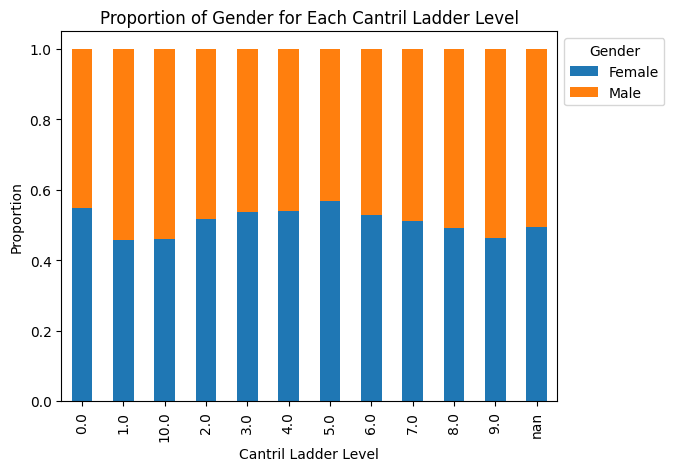

In [123]:
df0["cantril_ladder"] = df0["cantril_ladder"].astype(str)  # Convert to string for categorical representation

# Count the occurrences of each combination of cantril_ladder and gender
counts = df0.groupby(["cantril_ladder", "gender"]).size().unstack(fill_value=0)

# Calculate the proportion of each gender for each cantril_ladder level
proportions = counts.div(counts.sum(axis=1), axis=0)

# Plotting the bar chart
proportions.plot(kind="bar", stacked=True)

plt.title("Proportion of Gender for Each Cantril Ladder Level")
plt.xlabel("Cantril Ladder Level")
plt.ylabel("Proportion")
plt.legend(title="Gender", bbox_to_anchor=(1, 1))
plt.show()

In [23]:
print(df0["r1_1"].value_counts())
# remove string of agree and disagree
df0["r1_1"] = df0["r1_1"].replace("7 - Agree", 7)
df0["r1_1"] = df0["r1_1"].replace("1 – Disagree", 1)
print(df0["r1_1"].value_counts())

r1_1
7               9874
4               8506
5               7091
6               5446
3               5076
1 – Disagree    4580
2               4237
Name: count, dtype: int64
r1_1
7    9874
4    8506
5    7091
6    5446
3    5076
1    4580
2    4237
Name: count, dtype: int64


## compare those wear mask with diagonsed and without diagnosed

### plot face_mask_behaviour_binary

[['No' 5980 6403]
 ['None of these' 6827 8506]
 ['Prefer not to say' 311 398]
 ['Yes' 3091 2936]]
             dignose  face_mask_no  face_mask_yes  prop_face_mask_no  \
0                 No          5980           6403           0.482920   
1      None of these          6827           8506           0.445249   
2  Prefer not to say           311            398           0.438646   
3                Yes          3091           2936           0.512859   

   prop_face_mask_yes  
0            0.517080  
1            0.554751  
2            0.561354  
3            0.487141  


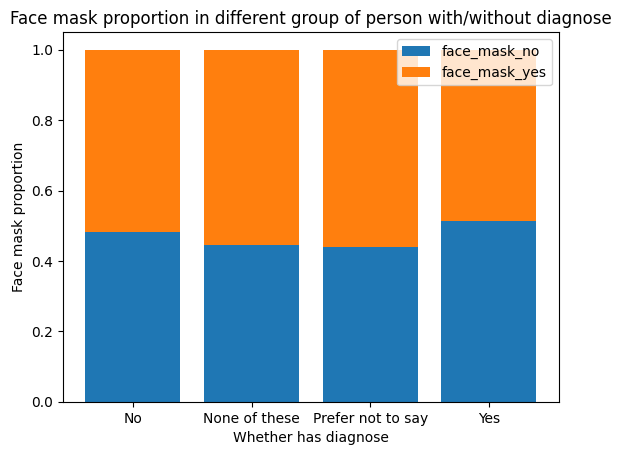

In [133]:
# x axis is people diagnised or not, y axis is proportion of the people wearing mask or not
diag_df = df.groupby(["d1_health_atleastone", "face_mask_behaviour_binary"]).size().unstack(fill_value=0).reset_index()
print(diag_df.values)
diag_df.columns = ["dignose", "face_mask_no", "face_mask_yes"]
# print(diag_df.columns)
total = diag_df["face_mask_no"] + diag_df["face_mask_yes"]
diag_df["prop_face_mask_no"] = diag_df["face_mask_no"]/total
diag_df["prop_face_mask_yes"] = diag_df["face_mask_yes"]/total
print(diag_df)

plt.bar(diag_df["dignose"], diag_df["prop_face_mask_no"], label = "face_mask_no")
plt.bar(diag_df["dignose"], diag_df["prop_face_mask_yes"], bottom= diag_df["prop_face_mask_no"], label="face_mask_yes")
plt.xlabel("Whether has diagnose")
plt.ylabel("Face mask proportion")
plt.title("Face mask proportion in different group of person with/without diagnose")
plt.legend()
plt.show()

### plot i12_health_1

i12_health_1_binary d1_health_atleastone     No    Yes
0                                     No  12183  16242
1                                    Yes   2812   3215
  dignose  face_mask_no  face_mask_yes  prop_face_mask_no  prop_face_mask_yes
0      No         12183          16242           0.428602            0.571398
1     Yes          2812           3215           0.466567            0.533433


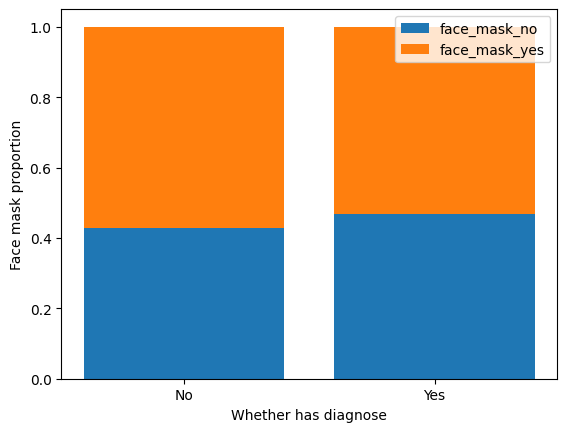

In [104]:
# x axis is people diagnised or not, y axis is proportion of the people wearing mask or not
diag_df = df["i12_health_1_binary"] = df["i12_health_1"].apply(lambda x: "Yes" if x >= 4 else "No")

diag_df = df.groupby(["d1_health_atleastone", "i12_health_1_binary"]).size().unstack(fill_value=0).reset_index()
print(diag_df)
# diag_df.columns = ["no_diagnise", "has_diagnise", "face_mask_yes", "face_mask_no"]
diag_df.columns = ["dignose",  "face_mask_no", "face_mask_yes"]

diag_df["prop_face_mask_no"] = diag_df["face_mask_no"]/(diag_df["face_mask_no"] + diag_df["face_mask_yes"])
diag_df["prop_face_mask_yes"] = diag_df["face_mask_yes"]/(diag_df["face_mask_no"] + diag_df["face_mask_yes"])
print(diag_df)

plt.bar(diag_df["dignose"], diag_df["prop_face_mask_no"], label = "face_mask_no")
plt.bar(diag_df["dignose"], diag_df["prop_face_mask_yes"], bottom= diag_df["prop_face_mask_no"], label="face_mask_yes")
plt.xlabel("Whether has diagnose")
plt.ylabel("Face mask proportion")
plt.legend()
plt.show()

## Compare with 0 threshold and 1006 threshold

In [ ]:
grouped_df0 = df0.groupby(["week_number", "i12_health_1"]).size().reset_index(name='count')

# Pivot the DataFrame
pivoted_df0 = grouped_df0.pivot_table(index='week_number', columns='i12_health_1', values='count', fill_value=0).reset_index()

# Calculate proportion_mask_no
pivoted_df0['proportion_mask_no'] = pivoted_df0[0] / (pivoted_df0[0] + pivoted_df0[1])

# Rename columns
pivoted_df0.columns = ['week_number', 'count_mask_no', 'count_mask_yes', 'proportion_mask_no']

# Convert columns to integer type
pivoted_df0[['count_mask_no', 'count_mask_yes']] = pivoted_df0[['count_mask_no', 'count_mask_yes']].astype(int)

# Print the resulting DataFrame
# print(pivoted_df0)

grouped_df = df.groupby(["week_number", "i12_health_1"]).size().reset_index(name='count')
# Pivot the DataFrame
pivoted_df = grouped_df.pivot_table(index='week_number', columns='i12_health_1', values='count', fill_value=0).reset_index()
# Calculate proportion_mask_no
pivoted_df['proportion_mask_no'] = pivoted_df[0] / (pivoted_df[0] + pivoted_df[1])
# Rename columns
pivoted_df.columns = ['week_number', 'count_mask_no', 'count_mask_yes', 'proportion_mask_no']

# Convert columns to integer type
pivoted_df[['count_mask_no', 'count_mask_yes']] = pivoted_df[['count_mask_no', 'count_mask_yes']].astype(int)

# Print the resulting DataFrame
# print(pivoted_df)

# df2 
grouped_df2 = df2.groupby(["week_number", "i12_health_1"]).size().reset_index(name='count')

# Pivot the DataFrame
pivoted_df2 = grouped_df2.pivot_table(index='week_number', columns='i12_health_1', values='count', fill_value=0).reset_index()
# Calculate proportion_mask_no
pivoted_df2['proportion_mask_no'] = pivoted_df2[0] / (pivoted_df2[0] + pivoted_df2[1])
# Rename columns
pivoted_df2.columns = ['week_number', 'count_mask_no', 'count_mask_yes', 'proportion_mask_no']

# Convert columns to integer type
pivoted_df2[['count_mask_no', 'count_mask_yes']] = pivoted_df2[['count_mask_no', 'count_mask_yes']].astype(int)

# Print the resulting DataFrame
# print(pivoted_df2)

# plot line plot between 0 and 1006
merged_df = pd.merge(pivoted_df0, pivoted_df, on='week_number', how='outer', suffixes=('_pivoted_df0', '_pivoted_df1006'))
# print(merged_df)
# plt.scatter(merged_df["proportion_mask_no_pivoted_df0"], merged_df["proportion_mask_no_pivoted_df1006"])

# plot line plot between 1006 and 10029
merged_df2 = pd.merge(pivoted_df2, pivoted_df, on='week_number', how='outer', suffixes=('_pivoted_df10029', '_pivoted_df1006'))
plt.scatter(merged_df2["proportion_mask_no_pivoted_df10029"], merged_df2["proportion_mask_no_pivoted_df1006"])

In [ ]:
#  As seen above, because more columns are included the trendency has been blocked from the result due to over-deleted rows with null



# Check whether cleaning is correct

In [241]:
# filter out those with missing values larger than 5000
import pandas as pd
# from missing_table import missing_value_df # Change: directly import the output from the missing_table
from datetime import datetime

# This function converts the string into the type of datetime %d/%m/%Y
def convert_datetime(dt):
    date = dt.split()[0]
    return datetime.strptime(date, "%d/%m/%Y")
        
# note: More needs to be added to this script to clean the columns as needs be

# edit: changed filed path
df = pd.read_csv("../raw_data/australia.csv",
                 na_values=[" ", "__NA__"], keep_default_na=True)

df["endtime"] = df["endtime"].apply(convert_datetime)

thresh_value = 10781

# Extract the variable names with missing value counts larger than 10781
missing_value_df = pd.read_csv('../data/missing_value_counts.csv')
columns_to_drop = missing_value_df.loc[missing_value_df['Missing Value Count']
                                       > thresh_value, 'Variable Name'].tolist()

df.drop(columns=columns_to_drop, inplace=True)

/var/folders/zw/qzpy5wgd4tn7wdrrtkxfybwh0000gn/T/ipykernel_1502/1699115184.py:14: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,15,16,17,19,22,31,37,38,39,40,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,77,78,79,81,82,83,84,85,86,87,88,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,2

In [242]:
print(df)

       RecordNo    endtime    qweek  i2_health i9_health        i11_health  \
0             0 2020-04-01   week 1        1.0       Yes      Very willing   
1             1 2020-04-01   week 1        6.0       Yes      Very willing   
2             2 2020-04-01   week 1        0.0       Yes      Very willing   
3             3 2020-04-01   week 1       20.0       Yes      Very willing   
4             4 2020-04-01   week 1        0.0       Yes  Somewhat willing   
...         ...        ...      ...        ...       ...               ...   
53828     53828 2022-03-28  week 54        NaN       Yes      Very willing   
53829     53829 2022-03-28  week 54        NaN        No    Very unwilling   
53830     53830 2022-03-28  week 54        NaN        No      Very willing   
53831     53831 2022-03-28  week 54        NaN       Yes      Very willing   
53832     53832 2022-03-28  week 54        NaN       Yes      Very willing   

      i12_health_1 i12_health_2 i12_health_3 i12_health_4  ... 

In [243]:
sdate = "2021-02-10" # Change: sdate -> 10-02-2021
edate = "2021-10-18"
mask = (df["endtime"] <= edate) & (df["endtime"] >= sdate)

for i in range(1,5):
    df.loc[mask, f"PHQ4_{i}"] = df.loc[mask, f"PHQ4_{i}"].fillna("N/A")
for i in range(1,14):
    df.loc[mask, f"d1_health_{i}"] = df.loc[mask, f"d1_health_{i}"].fillna("N/A")
for i in range(98,100):
    df.loc[mask, f"d1_health_{i}"] = df.loc[mask, f"d1_health_{i}"].fillna("N/A")
    

df.dropna(inplace=True)
print(df)

       RecordNo    endtime    qweek  i2_health i9_health  \
9023       9023 2020-06-24  week 10        0.0  Not sure   
9024       9024 2020-06-24  week 10        2.0        No   
9025       9025 2020-06-24  week 10        6.0       Yes   
9026       9026 2020-06-24  week 10       20.0       Yes   
9027       9027 2020-06-24  week 10        0.0       Yes   
...         ...        ...      ...        ...       ...   
51826     51826 2022-02-26  week 52        6.0        No   
51827     51827 2022-02-26  week 52        4.0       Yes   
51828     51828 2022-03-01  week 52        3.0       Yes   
51829     51829 2022-03-01  week 52       10.0       Yes   
51830     51830 2022-03-01  week 52      100.0        No   

                          i11_health i12_health_1 i12_health_2 i12_health_3  \
9023                        Not sure    Sometimes       Rarely    Sometimes   
9024                    Very willing   Frequently    Sometimes    Sometimes   
9025                    Very willing   Not

In [244]:
# Convert the string into values in scale
for i in range(1, 3):
    df[f"r1_{i}"] = df[f"r1_{i}"].replace({"7 - Agree": 7, "6": 6, "5": 5, "4":4, "3": 3, "2": 2, "1 – Disagree": 1}) # Change: change the string to int

frequency_dict = {"Always": 5, "Frequently": 4, "Sometimes": 3, "Rarely": 2, "Not at all": 1}
for column in df.columns:
    if column.startswith("i12_health_"):
        df[column] = df[column].map(frequency_dict)
print(df)

       RecordNo    endtime    qweek  i2_health i9_health  \
9023       9023 2020-06-24  week 10        0.0  Not sure   
9024       9024 2020-06-24  week 10        2.0        No   
9025       9025 2020-06-24  week 10        6.0       Yes   
9026       9026 2020-06-24  week 10       20.0       Yes   
9027       9027 2020-06-24  week 10        0.0       Yes   
...         ...        ...      ...        ...       ...   
51826     51826 2022-02-26  week 52        6.0        No   
51827     51827 2022-02-26  week 52        4.0       Yes   
51828     51828 2022-03-01  week 52        3.0       Yes   
51829     51829 2022-03-01  week 52       10.0       Yes   
51830     51830 2022-03-01  week 52      100.0        No   

                          i11_health  i12_health_1  i12_health_2  \
9023                        Not sure             3             2   
9024                    Very willing             4             3   
9025                    Very willing             1             5   
9026   

In [245]:
# Change: squash d1_health into one column
df["d1_health_atleastone"] = "No"
for index, row in df.iterrows():
    for col in df.columns:
        if col.startswith("d1_health") and col.endswith("1" or "2" or "3"or "4"or "5"or "6"or "7"or "8"or "9"or "10"or "11"or "12"or "13"):
            if row[col] == "Yes":
                df.at[index, "d1_health_atleastone"] = "Yes"
                break  # Exit the loop once a value of 1 is found
        elif col.startswith("d1_health") and col.endswith("98"):
            if row[col] == "Yes":
                df.at[index, "d1_health_atleastone"] = "Prefer not to say"
        elif col.startswith("d1_health") and col.endswith("99"):
            if row[col] == "Yes":
                df.at[index, "d1_health_atleastone"] = "None of these"
print(df)

       RecordNo    endtime    qweek  i2_health i9_health  \
9023       9023 2020-06-24  week 10        0.0  Not sure   
9024       9024 2020-06-24  week 10        2.0        No   
9025       9025 2020-06-24  week 10        6.0       Yes   
9026       9026 2020-06-24  week 10       20.0       Yes   
9027       9027 2020-06-24  week 10        0.0       Yes   
...         ...        ...      ...        ...       ...   
51826     51826 2022-02-26  week 52        6.0        No   
51827     51827 2022-02-26  week 52        4.0       Yes   
51828     51828 2022-03-01  week 52        3.0       Yes   
51829     51829 2022-03-01  week 52       10.0       Yes   
51830     51830 2022-03-01  week 52      100.0        No   

                          i11_health  i12_health_1  i12_health_2  \
9023                        Not sure             3             2   
9024                    Very willing             4             3   
9025                    Very willing             1             5   
9026   

In [246]:
# Change: have a face mask variable to be target in model i12_health_[1,22,23,25]
df["face_mask_behaviour_scale"] = df[["i12_health_1", "i12_health_22", "i12_health_23", "i12_health_25"]].median(axis = 1)

df["face_mask_behaviour_binary"] = df["face_mask_behaviour_scale"].apply(lambda x: "Yes" if x >= 4 else "No")
print(df)

       RecordNo    endtime    qweek  i2_health i9_health  \
9023       9023 2020-06-24  week 10        0.0  Not sure   
9024       9024 2020-06-24  week 10        2.0        No   
9025       9025 2020-06-24  week 10        6.0       Yes   
9026       9026 2020-06-24  week 10       20.0       Yes   
9027       9027 2020-06-24  week 10        0.0       Yes   
...         ...        ...      ...        ...       ...   
51826     51826 2022-02-26  week 52        6.0        No   
51827     51827 2022-02-26  week 52        4.0       Yes   
51828     51828 2022-03-01  week 52        3.0       Yes   
51829     51829 2022-03-01  week 52       10.0       Yes   
51830     51830 2022-03-01  week 52      100.0        No   

                          i11_health  i12_health_1  i12_health_2  \
9023                        Not sure             3             2   
9024                    Very willing             4             3   
9025                    Very willing             1             5   
9026   

In [247]:
df = df.drop(["RecordNo", "qweek", "weight"], axis = 1)
# create a new column in the csv that computer from week 1 for every two weeks
start_date = df['endtime'].min()
end_date = df['endtime'].max()

# Create a new column 'week_number' and assign week numbers
df['week_number'] = ((df['endtime'] - start_date).dt.days // 14) + 1
df.dropna(inplace=True)
print(df)

         endtime  i2_health i9_health                     i11_health  \
9023  2020-06-24        0.0  Not sure                       Not sure   
9024  2020-06-24        2.0        No                   Very willing   
9025  2020-06-24        6.0       Yes                   Very willing   
9026  2020-06-24       20.0       Yes               Somewhat willing   
9027  2020-06-24        0.0       Yes                   Very willing   
...          ...        ...       ...                            ...   
51826 2022-02-26        6.0        No               Somewhat willing   
51827 2022-02-26        4.0       Yes  Neither willing nor unwilling   
51828 2022-03-01        3.0       Yes                   Very willing   
51829 2022-03-01       10.0       Yes               Somewhat willing   
51830 2022-03-01      100.0        No               Somewhat willing   

       i12_health_1  i12_health_2  i12_health_3  i12_health_4  i12_health_5  \
9023              3             2             3         

In [252]:
print(df["household_size"].value_counts())

household_size
2                    14264
3                     7742
1                     7730
4                     6522
5                     2527
6                      827
Prefer not to say      677
Don't know             312
7                      287
8 or more              237
Name: count, dtype: int64


In [255]:
def household_convert(size_str):
    for i in range(1,8):
        if size_str == str(i):
            return i
        elif size_str == "8 or more":
            return 8
        elif size_str == "Prefer not to say" or size_str == "Don't know":
            return None
    
    
df["household_size"] = df["household_size"].apply(household_convert)

print(df["household_size"].value_counts())

household_size
2.0    14264
3.0     7742
1.0     7730
4.0     6522
5.0     2527
6.0      827
7.0      287
8.0      237
Name: count, dtype: int64


In [256]:
df.dropna(inplace=True)
print(df)

         endtime  i2_health i9_health                     i11_health  \
9023  2020-06-24        0.0  Not sure                       Not sure   
9024  2020-06-24        2.0        No                   Very willing   
9025  2020-06-24        6.0       Yes                   Very willing   
9026  2020-06-24       20.0       Yes               Somewhat willing   
9027  2020-06-24        0.0       Yes                   Very willing   
...          ...        ...       ...                            ...   
51826 2022-02-26        6.0        No               Somewhat willing   
51827 2022-02-26        4.0       Yes  Neither willing nor unwilling   
51828 2022-03-01        3.0       Yes                   Very willing   
51829 2022-03-01       10.0       Yes               Somewhat willing   
51830 2022-03-01      100.0        No               Somewhat willing   

       i12_health_1  i12_health_2  i12_health_3  i12_health_4  i12_health_5  \
9023              3             2             3         